In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
'''

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
browser = pd.read_csv('ab_browser_test.csv')

In [3]:
browser.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [9]:
print(((browser.groupby(['slot']).n_clicks.sum().exp / browser.groupby(['slot']).n_clicks.sum().control) - 1) * 100)

1.6135689824415822


In [15]:
browser.groupby(['slot']).count()

,userID,browser,n_clicks,n_queries,n_nonclk_queries
slot,,,,,
control,284554,284554,284554,284554,284554
exp,281580,281580,281580,281580,281580


In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
exp_clicks = browser.loc[browser.slot == 'exp'].n_clicks.to_numpy()
control_clicks  = browser.loc[browser.slot == 'control'].n_clicks.to_numpy()

In [14]:
np.random.seed(1234)

exp_clicks_mean = np.array(list(map(np.mean, get_bootstrap_samples(exp_clicks, 1000))))
exp_clicks_median = np.array(list(map(np.median, get_bootstrap_samples(exp_clicks, 1000))))

control_clicks_mean = np.array(list(map(np.mean, get_bootstrap_samples(control_clicks, 1000))))
control_clicks_median = np.array(list(map(np.median, get_bootstrap_samples(control_clicks, 1000))))

print("95% confidence interval for the exp group mean:",  stat_intervals(exp_clicks_mean, 0.05))
print("95% confidence interval for the exp group median:",  stat_intervals(exp_clicks_median, 0.05))

print("95% confidence interval for the control group mean:",  stat_intervals(control_clicks_mean, 0.05))
print("95% confidence interval for the control group median:",  stat_intervals(control_clicks_median, 0.05))


95% confidence interval for the exp group mean: [11.50640644 11.65842283]
95% confidence interval for the exp group median: [5. 5.]
95% confidence interval for the control group mean: [11.20417698 11.34814034]
95% confidence interval for the control group median: [4. 4.]


In [23]:
np.random.seed(0)
n_boot_samples = 500

control_boot_mean = np.array(list(map(np.mean, get_bootstrap_samples(control_clicks, n_boot_samples))))


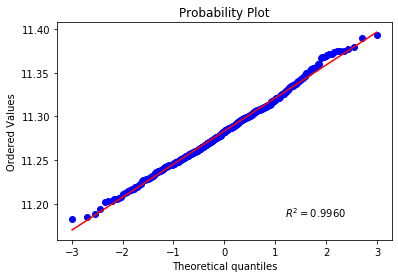

(0.03777466718563097, 11.283244614378994, 0.9979748364604202)


In [36]:
res = sc.stats.probplot(control_boot_mean, plot=plt, rvalue=True)
plt.show()

In [39]:
def ses(A):
    S = np.mean(A)
    return sum((A - S) ** 2)

control_boot_chi_squared = np.array(list(map(ses, get_bootstrap_samples(control_clicks, n_boot_samples))))

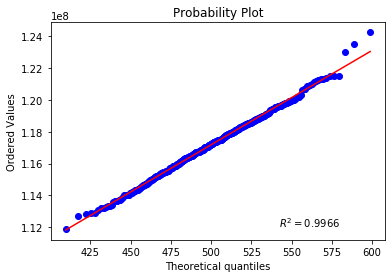

In [41]:
res = sc.stats.probplot(control_boot_chi_squared, dist='chi2', sparams=(n_boot_samples-1), plot=plt, rvalue=True)
plt.show()

In [60]:
table = pd.pivot_table(browser, values=['n_clicks'], index=['userID', 'slot'], aggfunc='sum')

In [64]:
sc.stats.mannwhitneyu(table.xs('exp', level='slot'), table.xs('control', level='slot'))

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [86]:
for bro in browser.browser.unique():
    print(bro)
    print(sc.stats.mannwhitneyu(browser.loc[(browser.slot == 'exp') & (browser.browser == bro)].n_clicks, browser.loc[(browser.slot == 'control') & (browser.browser == bro)].n_clicks))

Browser #2
MannwhitneyuResult(statistic=1522572720.0, pvalue=0.0272438604197241)
Browser #4
MannwhitneyuResult(statistic=3072447765.0, pvalue=0.40760617658454984)
Browser #14
MannwhitneyuResult(statistic=806984730.5, pvalue=0.0)
Browser #17
MannwhitneyuResult(statistic=131389681.0, pvalue=0.03740060143010802)
Browser #20
MannwhitneyuResult(statistic=143791805.0, pvalue=0.45366656388735377)
Browser #22
MannwhitneyuResult(statistic=2547597959.5, pvalue=0.2574055152210032)


In [87]:
browser.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [90]:
browser['nonclk_proc'] = browser.n_nonclk_queries / browser.n_queries * 100

In [91]:
browser.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,nonclk_proc
0,1,Browser #2,exp,23,32,19,59.375000
1,3,Browser #4,exp,3,4,2,50.000000
2,5,Browser #4,exp,29,35,16,45.714286
3,6,Browser #4,control,12,6,0,0.000000
4,7,Browser #4,exp,54,68,30,44.117647


In [95]:
table = pd.pivot_table(browser, values=['nonclk_proc'], index=['browser', 'slot'], aggfunc='mean')
table

nonclk_proc
browser     slot                
Browser #14 control    60.075333
            exp        43.107418
Browser #17 control    36.752502
            exp        36.658605
Browser #2  control    46.412984
            exp        45.538104
Browser #20 control    39.077033
            exp        37.862934
Browser #22 control    39.432059
            exp        39.072203
Browser #4  control    44.476226
            exp        43.008149